**Chapter 4 – Text Classification**
#### I will be following the chapter activities!

In [1]:
import numpy as np
import pandas as pd #to work with csv files

#matplotlib imports are used to plot confusion matrices for the classifiers
import matplotlib as mpl 
import matplotlib.cm as cm 
import matplotlib.pyplot as plt 

#import feature extraction methods from sklearn
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction import stop_words

#pre-processing of text
import string
import re

#import classifiers from sklearn
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC

#import different metrics to evaluate the classifiers
from sklearn.metrics import accuracy_score
#from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix 
from sklearn import metrics

#import time function from time module to track the training duration
from time import time

/home/marcos/anaconda3/lib/python3.7/site-packages/sklearn/utils/deprecation.py:143: FutureWarning: The sklearn.feature_extraction.stop_words module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.feature_extraction.text. Anything that cannot be imported from sklearn.feature_extraction.text is now part of the private API.
  warnings.warn(message, FutureWarning)


## Loading and Exploring Data

In [2]:
!wget -P DATAPATH https://raw.githubusercontent.com/practical-nlp/practical-nlp/master/Ch4/Data/Full-Economic-News-DFE-839861.csv
!ls -lah DATAPATH

--2021-03-08 10:08:11--  https://raw.githubusercontent.com/practical-nlp/practical-nlp/master/Ch4/Data/Full-Economic-News-DFE-839861.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.108.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 12383529 (12M) [text/plain]
Saving to: ‘DATAPATH/Full-Economic-News-DFE-839861.csv’

Full-Economic-News- 100%[===================>]  11.81M  1.13MB/s    in 10s     

2021-03-08 10:08:22 (1.14 MB/s) - ‘DATAPATH/Full-Economic-News-DFE-839861.csv’ saved [12383529/12383529]

total 12M
drwxr-xr-x 2 marcos marcos 4.0K Mar  8 10:08 .
drwxr-xr-x 4 marcos marcos 4.0K Mar  8 10:08 ..
-rw-r--r-- 1 marcos marcos  12M Mar  8 10:08 Full-Economic-News-DFE-839861.csv


In [3]:
our_data = pd.read_csv("DATAPATH/Full-Economic-News-DFE-839861.csv" , encoding = "ISO-8859-1" )

display(our_data.shape) #Number of rows (instances) and columns in the dataset
our_data["relevance"].value_counts()/our_data.shape[0] #Class distribution in the dataset

(8000, 15)

no          0.821375
yes         0.177500
not sure    0.001125
Name: relevance, dtype: float64

In [4]:
# convert label to a numerical variable
our_data = our_data[our_data.relevance != "not sure"]
our_data.shape
our_data['relevance'] = our_data.relevance.map({'yes':1, 'no':0}) #relevant is 1, not-relevant is 0. 
our_data = our_data[["text","relevance"]] #Let us take only the two columns we need.
our_data.shape

(7991, 2)

## Text Preprocessing

In [5]:
stopwords = stop_words.ENGLISH_STOP_WORDS
def clean(doc): #doc is a string of text
    doc = doc.replace("</br>", " ") #This text contains a lot of <br/> tags.
    doc = "".join([char for char in doc if char not in string.punctuation and not char.isdigit()])
    doc = " ".join([token for token in doc.split() if token not in stopwords])
    #remove punctuation and numbers
    return doc

## Modelling

In [6]:
import sklearn
#from sklearn.cross_validation import train_test_split
from sklearn.model_selection import train_test_split

#Step 1: train-test split
X = our_data.text #the column text contains textual data to extract features from
y = our_data.relevance #this is the column we are learning to predict. 
print(X.shape, y.shape)
# split X and y into training and testing sets. By default, it splits 75% training and 25% test
#random_state=1 for reproducibility
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(7991,) (7991,)
(5993,) (5993,)
(1998,) (1998,)


In [7]:
#Step 2-3: Preprocess and Vectorize train and test data
vect = CountVectorizer(preprocessor=clean) #instantiate a vectoriezer
X_train_dtm = vect.fit_transform(X_train)#use it to extract features from training data
#transform testing data (using training data's features)
X_test_dtm = vect.transform(X_test)
print(X_train_dtm.shape, X_test_dtm.shape)
#i.e., the dimension of our feature vector is 49753!

(5993, 49753) (1998, 49753)


In [8]:
#Step 3: Train the classifier and predict for test data
nb = MultinomialNB() #instantiate a Multinomial Naive Bayes model
%time nb.fit(X_train_dtm, y_train)#train the model(timing it with an IPython "magic command")
y_pred_class = nb.predict(X_test_dtm)#make class predictions for X_test_dtm

CPU times: user 6.95 ms, sys: 0 ns, total: 6.95 ms
Wall time: 6.39 ms


Accuracy:  0.7822822822822822
ROC_AOC_Score:  0.7251117679464362


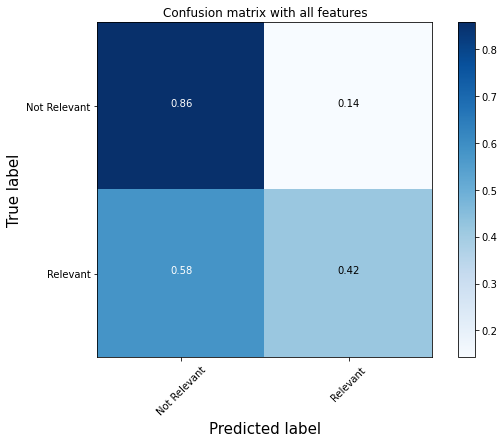

In [9]:
#Step 4: Evaluate the classifier using various measures

# Function to plot confusion matrix. 
# Ref:http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html
import itertools
from sklearn.metrics import roc_auc_score

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label',fontsize=15)
    plt.xlabel('Predicted label',fontsize=15)
    
    
#Print accuracy:
print("Accuracy: ", accuracy_score(y_test, y_pred_class))

    
# print the confusion matrix
cnf_matrix = confusion_matrix(y_test, y_pred_class)
plt.figure(figsize=(8,6))
plot_confusion_matrix(cnf_matrix, classes=['Not Relevant','Relevant'],normalize=True,
                      title='Confusion matrix with all features')

# calculate AUC: Area under the curve(AUC) gives idea about the model efficiency:
#Further information: https://en.wikipedia.org/wiki/Receiver_operating_characteristic
y_pred_prob = nb.predict_proba(X_test_dtm)[:, 1]
print("ROC_AOC_Score: ", roc_auc_score(y_test, y_pred_prob))

CPU times: user 2.76 ms, sys: 754 µs, total: 3.52 ms
Wall time: 3.52 ms
Accuracy:  0.6876876876876877


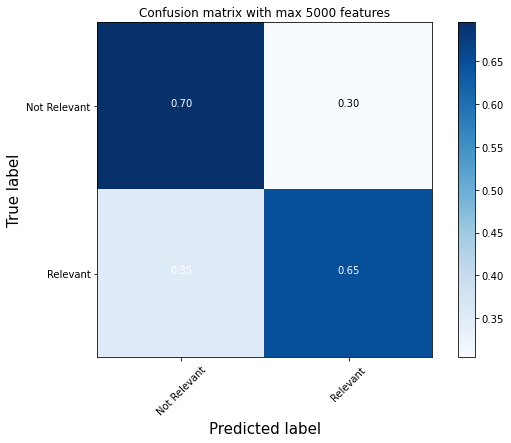

In [10]:
vect = CountVectorizer(preprocessor=clean, max_features=5000) #Step-1
X_train_dtm = vect.fit_transform(X_train)#combined step 2 and 3
X_test_dtm = vect.transform(X_test)
nb = MultinomialNB() #instantiate a Multinomial Naive Bayes model
%time nb.fit(X_train_dtm, y_train)#train the model(timing it with an IPython "magic command")
y_pred_class = nb.predict(X_test_dtm)#make class predictions for X_test_dtm
print("Accuracy: ", metrics.accuracy_score(y_test, y_pred_class))
# print the confusion matrix
cnf_matrix = confusion_matrix(y_test, y_pred_class)
plt.figure(figsize=(8,6))
plot_confusion_matrix(cnf_matrix, classes=['Not Relevant','Relevant'],normalize=True,
                      title='Confusion matrix with max 5000 features')

Accuracy:  0.7372372372372372
AUC:  0.7251117679464362


/home/marcos/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


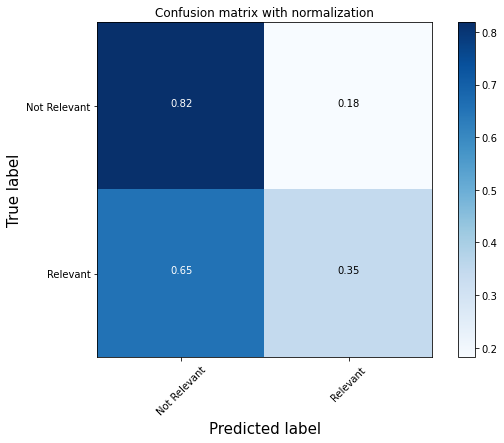

In [11]:
from sklearn.linear_model import LogisticRegression #import

logreg = LogisticRegression(class_weight="balanced") #instantiate a logistic regression model
logreg.fit(X_train_dtm, y_train) #fit the model with training data

#Make predictions on test data
y_pred_class = logreg.predict(X_test_dtm)

#calculate evaluation measures:
print("Accuracy: ", accuracy_score(y_test, y_pred_class))
print("AUC: ", roc_auc_score(y_test, y_pred_prob))
cnf_matrix = confusion_matrix(y_test, y_pred_class)
plt.figure(figsize=(8,6))
plot_confusion_matrix(cnf_matrix, classes=['Not Relevant','Relevant'],normalize=True,
                      title='Confusion matrix with normalization')

Accuracy:  0.6926926926926927
AUC:  0.7251117679464362


/home/marcos/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


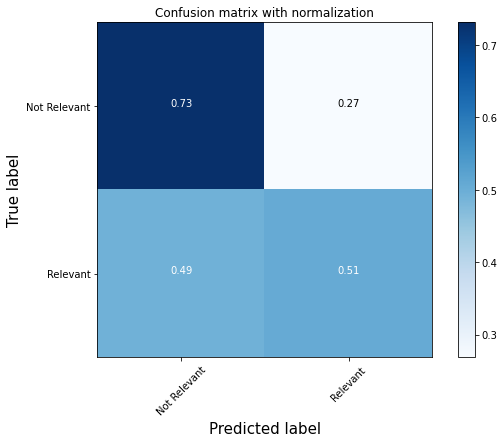

In [12]:
from sklearn.svm import LinearSVC

vect = CountVectorizer(preprocessor=clean, max_features=1000) #Step-1
X_train_dtm = vect.fit_transform(X_train)#combined step 2 and 3
X_test_dtm = vect.transform(X_test)

classifier = LinearSVC(class_weight='balanced') #instantiate a logistic regression model
classifier.fit(X_train_dtm, y_train) #fit the model with training data

#Make predictions on test data
y_pred_class = classifier.predict(X_test_dtm)

#calculate evaluation measures:
print("Accuracy: ", accuracy_score(y_test, y_pred_class))
print("AUC: ", roc_auc_score(y_test, y_pred_prob))
cnf_matrix = confusion_matrix(y_test, y_pred_class)
plt.figure(figsize=(8,6))
plot_confusion_matrix(cnf_matrix, classes=['Not Relevant','Relevant'],normalize=True,
                      title='Confusion matrix with normalization')